# 02 - Data from the Web

Contents :
* [0. Preliminary analysis and observations](#0.-Preliminary-analysis-and-observations)
* [1. Bachelor duration](#1.-Bachelor-duration)
* [2. Master duration](#2.-Master-duration)

We use postman to understand the parameters used by the url request, asked for the exercise.

(However, notice that there are equivalent tools for other browser - for instance, for firefox:
http://stackoverflow.com/questions/28997326/postman-addons-like-in-firefox)

In [2]:
# important modules for this HW
import bs4 # doc: https://www.crummy.com/software/BeautifulSoup/bs4/doc/
import requests as rq 


# previous useful modules
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

## 0. Preliminary analysis and observations

For all the information and data we want to retrieve, the main access is the form located at this URL : http://isa.epfl.ch/imoniteur_ISAP/%21gedpublicreports.htm?ww_i_reportmodel=133685247.

A first visit to this page with *Postman Interceptor* activated shows that this page is actually built from several parts loaded by scripts. Among those parts, we are particularly interested by the one that contains the form itself (*ie.* the select menus). The source for this part is obtained by fetching content from this URL : http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247.
So, to get all the parameters programmatically, one can get this HTML code using the *requests* module and scrape it with *BeautifulSoup*.

In [3]:
form_source = rq.get("http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247")
form_soup = bs4.BeautifulSoup(form_source.text, "html.parser")

We can take a look at the "pretiffied" HTML code. The most relevant parts are all the `input` and `select` tags.

In [4]:
# print(form_soup.prettify())

Let's get all the `select` menus of the page, using the `find_all` method of *BeautifulSoup* which allows to search for all tags of a certain type.

In [5]:
selectors = form_soup.find_all('select')
print(len(selectors))

4


Most importantly, we can find out what each tag is about by printing the its `name` attribute :

In [6]:
for num, s in enumerate(selectors):
    print("Select n°{} : {}".format(num, s.attrs['name'])) # wild french appears...

Select n°0 : ww_x_UNITE_ACAD
Select n°1 : ww_x_PERIODE_ACAD
Select n°2 : ww_x_PERIODE_PEDAGO
Select n°3 : ww_x_HIVERETE


So :
* the first select is about the academic unit
* the second select is about the academic year
* the third select is about the academic level
* the fourth select is about the semester (fall or spring)

Going deeper into the HTML code, we can get all the possible choices for each select tag by searching for inner `option` tags. The content or body of those tags is the human readable description. Each choice is mapped to a number by its `value` attribute.

In [7]:
for s in selectors:
    options = s.find_all('option')
    options_desc_values = [(o.text, o.attrs['value']) for o in options]
    print(s.attrs['name'] + ':')
    for (d,v) in options_desc_values:
        print("- {} [{}]".format(d,v)) # more french

ww_x_UNITE_ACAD:
-  [null]
- Architecture [942293]
- Chimie et génie chimique [246696]
- Cours de mathématiques spéciales [943282]
- EME (EPFL Middle East) [637841336]
- Génie civil [942623]
- Génie mécanique [944263]
- Génie électrique et électronique  [943936]
- Humanités digitales [2054839157]
- Informatique [249847]
- Ingénierie financière [120623110]
- Management de la technologie [946882]
- Mathématiques [944590]
- Microtechnique [945244]
- Physique [945571]
- Science et génie des matériaux [944917]
- Sciences et ingénierie de l'environnement [942953]
- Sciences et technologies du vivant [945901]
- Section FCUE [1574548993]
- Systèmes de communication [946228]
ww_x_PERIODE_ACAD:
-  [null]
- 2016-2017 [355925344]
- 2015-2016 [213638028]
- 2014-2015 [213637922]
- 2013-2014 [213637754]
- 2012-2013 [123456101]
- 2011-2012 [123455150]
- 2010-2011 [39486325]
- 2009-2010 [978195]
- 2008-2009 [978187]
- 2007-2008 [978181]
ww_x_PERIODE_PEDAGO:
-  [null]
- Bachelor semestre 1 [249108]
- Ba

The presence of (`''`, `null`) tuples comes from the "empty" (no choice selected) select tags when we load the page. Also, let's remember that we will focus exclusively on the academic unit "Informatique". We'll get back to that later.

Finally, we can try to actually send a request (manually) to get some data. *Postman* helps us to identify the URL scheme used for this :
* for HTML result, the URL has the following structure :

```
http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_x_GPS=2021043255&ww_i_reportModel=133685247&ww_i_reportModelXsl=133685270&ww_x_UNITE_ACAD=249847&ww_x_PERIODE_ACAD=355925344&ww_x_PERIODE_PEDAGO=249108&ww_x_HIVERETE=2936286
```

* for XLS result, the URL has the following structure :

```
http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.XLS?ww_x_GPS=2021043255&ww_i_reportModel=133685247&ww_i_reportModelXsl=133685271&ww_x_UNITE_ACAD=249847&ww_x_PERIODE_ACAD=355925344&ww_x_PERIODE_PEDAGO=249108&ww_x_HIVERETE=2936286
```

Thus, the only difference between the two is the `.html` or `.XLS` part, which makes sense. Assuming we put "good" parameters inside the `< ... >`, each request will therefore encoded by this type of URL :

```
http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.<format>?ww_x_GPS=2021043255&ww_i_reportModel=133685247&ww_i_reportModelXsl=<format code>&ww_x_UNITE_ACAD=<unit code>&ww_x_PERIODE_ACAD=<year code>&ww_x_PERIODE_PEDAGO=<level code>&ww_x_HIVERETE=<semester code>
```

## Let's get some data

Based on what we've explained before, and since the data structure is consistent, we can now start collecting some data from IS-Academia in a pandas DataFrame.

In [8]:
base_url = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?"
params_dict = {
    'ww_x_GPS': 2021043255,
    'ww_i_reportModel': 133685247,
    'ww_i_reportModelXsl': 133685270,
    'ww_x_UNITE_ACAD': 249847,
    'ww_x_PERIODE_ACAD': 355925344,
    'ww_x_PERIODE_PEDAGO': 249108,
    'ww_x_HIVERETE':2936286
}

In [9]:
# Get raw HTML response
result_html = rq.get(base_url,params=params_dict)

# Use BeautifulSoup and extract the first (and only) HTML table
result_soup = bs4.BeautifulSoup(result_html.text, "lxml")
result_table = result_soup.find_all('table')[0]

# print(result_table.prettify())

In [10]:
df = pd.read_html(result_table.decode())[0]
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,"Informatique, 2016-2017, Bachelor semestre 1 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,No Sciper,NaN
2,Monsieur,Abbey Alexandre,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,235688,NaN
3,Monsieur,Ahn Seongho,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,274015,NaN
4,Madame,Alemanno Sara,NaN,NaN,NaN,NaN,NaN,Présent,NaN,NaN,268410,NaN


In [11]:
df.columns = df.loc[1]                # use row 2 as column names
df = df.drop([0, 1])                  # drop useless first rows
df = df.drop([np.nan], axis=1)        # drop useless nan column
df.index = df['No Sciper']            # use sciper column as index

# Drop some columns
df = df.drop(['Orientation Bachelor', 'Orientation Master', 'Filière opt.', 'Type Echange', 'Ecole Echange'], axis=1)

# Do some renaming
df.index.name = 'sciper'
df.columns = ['gender', 'full_name', 'specialization', 'minor', 'status', 'sciper']

# Map gender to more standard names
dict_gender = {'Monsieur': 'male','Madame': 'female'}
df.gender.replace(dict_gender, inplace=True)
df.head()

,gender,full_name,specialization,minor,status,sciper
sciper,,,,,,
235688,male,Abbey Alexandre,NaN,NaN,Présent,235688
274015,male,Ahn Seongho,NaN,NaN,Présent,274015
268410,female,Alemanno Sara,NaN,NaN,Présent,268410
271464,male,Althaus Luca,NaN,NaN,Présent,271464
274518,male,Assi Karim,NaN,NaN,Présent,274518


## Some tools

We can define a helper function which, given a base URL and a dictionary of parameters, will fetch the data and fill a DataFrame with it.

In [12]:
def get_data(base_url, params_dict):
    """Get data from IS-Academia in a pandas DataFrame"""
    
    # Same sequence of operations of above, with a check if the result_table is empty
    
    result_html = rq.get(base_url,params=params_dict)
    result_soup = bs4.BeautifulSoup(result_html.text, "lxml")
    result_table = result_soup.find_all('table')[0]
    
    if (result_table.text == ''):
        # Return empty dataframe
        df = pd.DataFrame()
    else:
        # Build a DataFrame containing the data, with SCIPER as index
        df = pd.read_html(result_table.decode())[0]
        try:
            df.columns = df.loc[1]                # use 2nd row as column names
            df = df.drop([0, 1])                  # drop useless first rows
            df = df.drop([np.nan], axis=1)        # drop useless nan column
            df.index = df['No Sciper']            # use sciper column as index
        
            # Drop some columns
            df = df.drop(['Orientation Bachelor', 'Orientation Master', 'Filière opt.', 'Type Echange', 'Ecole Echange'], axis=1)
            # Do some renaming
            df.index.name = 'sciper'
            df.columns = ['gender', 'full_name', 'specialization', 'minor', 'status', 'sciper']
            # Map gender to more standard names
            dict_gender = {'Monsieur': 'male','Madame': 'female'}
            df.gender.replace(dict_gender, inplace=True)
        except:
            df = pd.DataFrame()
    
    return df

The following lines test this function with hardcoded values :

In [13]:
base_url = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?"
params_dict = {
    'ww_x_GPS': 2021043255,
    'ww_i_reportModel': 133685247,
    'ww_i_reportModelXsl': 133685270,
    'ww_x_UNITE_ACAD': 249847,
    'ww_x_PERIODE_ACAD': 355925344,
    'ww_x_PERIODE_PEDAGO': 249108,
    'ww_x_HIVERETE':2936286
}

get_data(base_url, params_dict).head()

,gender,full_name,specialization,minor,status,sciper
sciper,,,,,,
235688,male,Abbey Alexandre,NaN,NaN,Présent,235688
274015,male,Ahn Seongho,NaN,NaN,Présent,274015
268410,female,Alemanno Sara,NaN,NaN,Présent,268410
271464,male,Althaus Luca,NaN,NaN,Présent,271464
274518,male,Assi Karim,NaN,NaN,Présent,274518


Finally let's get all the possible values in a cleaner way and keep them in variables that we will use throughout this notebook.

In [14]:
acad_period = {}
level = {}
semester = {}
acad_unit = {}

for s in selectors:
    options = s.find_all('option')
    options_desc_values = [(o.text, o.attrs['value']) for o in options]
    s_name = s.attrs['name']
    choices = {d: int(v) for (d,v) in options_desc_values if d!=''}
    
    if s_name == 'ww_x_PERIODE_ACAD':
        acad_period = choices
    elif s_name == 'ww_x_PERIODE_PEDAGO':
        level = choices
    elif s_name == 'ww_x_HIVERETE':
        for (d,v) in options_desc_values:
            if 'automne' in d:
                semester['automne'] = int(v)
            elif 'printemps' in d:
                semester['printemps'] =int(v)
    elif s_name == 'ww_x_UNITE_ACAD':
        acad_unit = choices

# Example of result
acad_period

{'2007-2008': 978181,
 '2008-2009': 978187,
 '2009-2010': 978195,
 '2010-2011': 39486325,
 '2011-2012': 123455150,
 '2012-2013': 123456101,
 '2013-2014': 213637754,
 '2014-2015': 213637922,
 '2015-2016': 213638028,
 '2016-2017': 355925344}

## 1. Bachelor duration

### Store data locally

First, we can get all the data about bachelor once and for all, and store it locally using `pickle`. This way, we can work on local data and not kill the IS-Academia servers. The local files are named after the parameters combinations, for example `2007-2008-bachelor-semetre-2-automne`.

In [15]:
# Get bachelor data for every year and store it if it's not empty
import os
local_dir = '.local-data'
try:
    os.mkdir(local_dir)
except FileExistsError:
    # directory exists
    print("Using existing '" + local_dir + "' directory")

Using existing '.local-data' directory


In [15]:
# Fixed values
params_dict = {
    'ww_x_GPS': -1,
    'ww_i_reportModel': 133685247,
    'ww_i_reportModelXsl': 133685270,
    'ww_x_UNITE_ACAD': acad_unit['Informatique']
}

# Iterate over all the varying params and keep only data for bachelors
for year_key, year_value in acad_period.items():
    for level_key, level_value in level.items():
        for semester_key, semester_value in semester.items():
            if 'bachelor' in level_key.lower():
                params_dict['ww_x_PERIODE_ACAD'] = year_value
                params_dict['ww_x_PERIODE_PEDAGO'] = level_value
                params_dict['ww_x_HIVERETE'] = semester_value
                
                df = get_data(base_url, params_dict)
                if not df.empty:
                    # Persist dataframe locally with pickle
                    filename = year_key + '-' + level_key.replace(' ', '-').lower() + '-' + semester_key
                    df.to_pickle(local_dir + '/' + filename)

In [16]:
# the previous cell should download 60 files!, as you can check with this command:
print(len([name for name in os.listdir(local_dir)]))

60


We want to remark that there is no data for _ 'Bachelor semestre 5b':2226768_ and _'Bachelor semestre 6b':2226785_  (as we named the files with the names of html parameters, you can simply check it from the file names) 

We hereby show an example of dataframe laoded from the files previously download:

In [17]:
df_example = pd.read_pickle(local_dir + '/2007-2008-bachelor-semestre-6-printemps')
df_example.head()

,gender,full_name,specialization,minor,status,sciper
sciper,,,,,,
170220,male,Barras Florian,NaN,NaN,Présent,170220
166701,male,Beuret Thibaut,NaN,NaN,Présent,166701
161279,male,Biollay Jean Isaac Jamal Pachacutec,NaN,NaN,Présent,161279
166344,male,Blatter Jérémy,NaN,NaN,Présent,166344
161634,male,Boksanyi Michael,NaN,NaN,Présent,161634


### Get data about bachelor students

We load data about bachelor students in several dataframes, that we will concatenate by 'level' after.

In [18]:
# Get data about all bachelor semesters
ba = ['bachelor-semestre-{}'.format(i+1) for i in range(6)]
ba_dfs = {ba[i]:{} for i in range(6)}

for year_key, year_value in acad_period.items():
    for file in os.listdir(local_dir):
        for i in range(6):
            if (year_key in file) and (ba[i] in file):
                # Read pickle file
                df = pd.read_pickle(local_dir + '/' + file)
                df['ba{}'.format(i+1)] = year_key
                ba_dfs[ba[i]][year_key] = df

In [19]:
# Concatenate all bachelor-i together, for all i
ba_dfs_concat = {ba[i]:pd.concat(ba_dfs[ba[i]].values(), axis=0) for i in range(6)}

Mind that, on the one hand, there is one _sciper_ per _student_, as expected (as a check, you can compare below the num. of unique values for _sciper_ and _full name_):

In [20]:
ba_dfs_concat['bachelor-semestre-1'].describe()

,gender,full_name,specialization,minor,status,sciper,ba1
count,1720,1720,0.0,0.0,1720,1720,1720
unique,2,1324,0.0,0.0,3,1324,10
top,male,Barraud Laurent François Michaël,NaN,NaN,Présent,250473,2014-2015
freq,1558,3,NaN,NaN,1714,3,242


In [21]:
ba_dfs_concat['bachelor-semestre-6'].describe()

,gender,full_name,specialization,minor,status,sciper,ba6
count,664,664,0.0,0.0,664,664,664
unique,2,516,0.0,0.0,3,516,10
top,male,Aiulfi Loris Sandro,NaN,NaN,Présent,202293,2014-2015
freq,621,3,NaN,NaN,530,3,116


...on the other, there are repetitions (find below, the distribution of times ba1 / ba6 has been repetead):

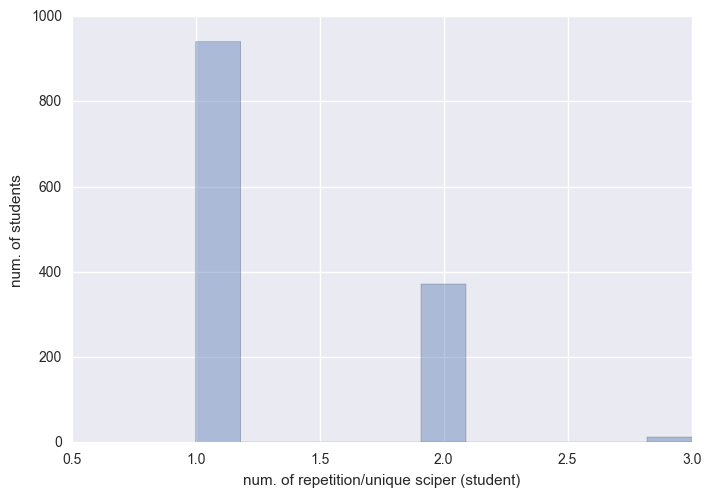

In [22]:
sns.distplot(ba_dfs_concat['bachelor-semestre-1'].sciper.value_counts(),kde=False,axlabel='num. of repetition/unique sciper (student)')
plt.ylabel('num. of students')

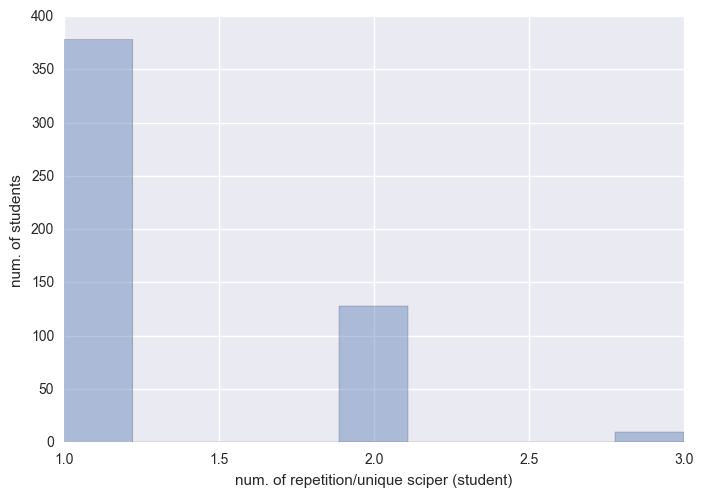

In [23]:
sns.distplot(ba_dfs_concat['bachelor-semestre-6'].sciper.value_counts(),kde=False,axlabel='num. of repetition/unique sciper (student)')
plt.ylabel('num. of students')

The next step is to count how many times each student appear in each level, that is count the number of times a student has done a semester.

In [24]:
count_ba = {}
for i in range(6):
    count_ba[ba[i]] = pd.DataFrame(ba_dfs_concat[ba[i]].groupby('sciper',as_index=False).size(), columns=['count_ba{}'.format(i+1)])
    count_ba[ba[i]]['sciper'] = count_ba[ba[i]].index

Then, we can put all the data we have in a single dataframe that we will use to compute the results and the stats.

In [25]:
bachelor_df = pd.merge(ba_dfs_concat[ba[0]], ba_dfs_concat[ba[1]], how='outer')
bachelor_df = pd.merge(bachelor_df, ba_dfs_concat[ba[2]], how='outer')
bachelor_df = pd.merge(bachelor_df, ba_dfs_concat[ba[3]], how='outer')
bachelor_df = pd.merge(bachelor_df, ba_dfs_concat[ba[4]], how='outer')
bachelor_df = pd.merge(bachelor_df, ba_dfs_concat[ba[5]], how='outer')

for i in range(6):
    bachelor_df = pd.merge(bachelor_df, count_ba[ba[i]], how='outer')
    bachelor_df['count_ba{}'.format(i+1)] = bachelor_df['count_ba{}'.format(i+1)].fillna(value=0)

bachelor_df = bachelor_df.drop_duplicates(['sciper'])
bachelor_df.head()

,gender,full_name,specialization,minor,status,sciper,ba1,ba2,ba3,ba4,ba5,ba6,count_ba1,count_ba2,count_ba3,count_ba4,count_ba5,count_ba6
0,male,Ahluwalia Samit,NaN,NaN,Présent,184228,2008-2009,2008-2009,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0
1,male,Amiet Nils,NaN,NaN,Présent,179383,2008-2009,2008-2009,2009-2010,2009-2010,2010-2011,NaN,1.0,1.0,1.0,1.0,1.0,0.0
2,male,Andenmatten Alexandre,NaN,NaN,Présent,186836,2008-2009,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0
3,male,Arnfred Jonas,NaN,NaN,Présent,184772,2008-2009,2008-2009,2009-2010,2009-2010,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0
5,male,Badila Constantin-Tudor,NaN,NaN,Présent,187235,2008-2009,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0


To compute the duration of the bachelor, we define a compute_duration function that takes the names of the columns containing the 'counts' as a parameter, and compute the duration in months. Then, we apply this function to our dataframe.

In [22]:
def compute_duration(x, columns):
    return sum([x[c] for c in columns]) * 6

In [27]:
columns = ['count_ba{}'.format(i+1) for i in range(6)]
bachelor_df['duration'] = bachelor_df.apply(compute_duration, axis=1, args=(columns,))
bachelor_df.head()

,gender,full_name,specialization,minor,status,sciper,ba1,ba2,ba3,ba4,ba5,ba6,count_ba1,count_ba2,count_ba3,count_ba4,count_ba5,count_ba6,duration
0,male,Ahluwalia Samit,NaN,NaN,Présent,184228,2008-2009,2008-2009,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,12.0
1,male,Amiet Nils,NaN,NaN,Présent,179383,2008-2009,2008-2009,2009-2010,2009-2010,2010-2011,NaN,1.0,1.0,1.0,1.0,1.0,0.0,30.0
2,male,Andenmatten Alexandre,NaN,NaN,Présent,186836,2008-2009,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,6.0
3,male,Arnfred Jonas,NaN,NaN,Présent,184772,2008-2009,2008-2009,2009-2010,2009-2010,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,36.0
5,male,Badila Constantin-Tudor,NaN,NaN,Présent,187235,2008-2009,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,6.0


Finally, we filter the results to keep only the students who have entries for both bachelor semester 1 and semester 6.

In [28]:
# Keep only students with entries for both BA1 and BA6
bachelor_df_filtered = bachelor_df[(bachelor_df.count_ba1>0) & (bachelor_df.count_ba6>0)]
bachelor_df_filtered.head()

,gender,full_name,specialization,minor,status,sciper,ba1,ba2,ba3,ba4,ba5,ba6,count_ba1,count_ba2,count_ba3,count_ba4,count_ba5,count_ba6,duration
3,male,Arnfred Jonas,NaN,NaN,Présent,184772,2008-2009,2008-2009,2009-2010,2009-2010,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,36.0
6,male,Bougacha Malik,NaN,NaN,Présent,186264,2008-2009,2008-2009,2010-2011,2010-2011,2013-2014,2012-2013,2.0,2.0,1.0,1.0,3.0,2.0,66.0
30,male,Bourgeois Jérémy,NaN,NaN,Présent,185949,2008-2009,2008-2009,2009-2010,2009-2010,2010-2011,2010-2011,1.0,1.0,1.0,1.0,1.0,1.0,36.0
31,male,Bourqui Marc,NaN,NaN,Présent,184264,2008-2009,2008-2009,2010-2011,2010-2011,2012-2013,2012-2013,2.0,2.0,1.0,1.0,2.0,2.0,60.0
47,male,Bruchez Lionel,NaN,NaN,Présent,186825,2008-2009,2008-2009,2009-2010,2009-2010,2011-2012,2010-2011,1.0,1.0,1.0,1.0,2.0,1.0,42.0


Here we plot a pychart of the duration, for all students (with both ba1 and ba6):

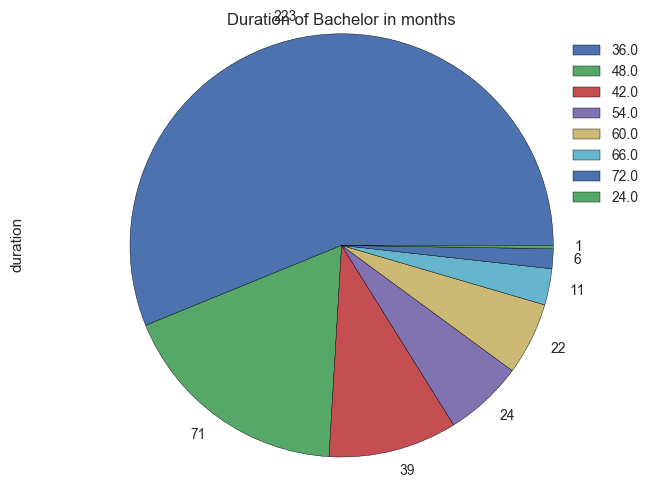

In [29]:
counts = bachelor_df_filtered.duration.value_counts()
counts.plot(kind='pie', labels=counts.values)
plt.legend(labels=counts.index)
plt.axis('equal')
plt.title('Duration of Bachelor in months')

### Some stats

Now we can have stats about bachelor duration for _all selected_ students:

In [30]:
bachelor_df_filtered.duration.describe()

count    397.000000
mean      42.498741
std        9.146569
min       24.000000
25%       36.000000
50%       36.000000
75%       48.000000
max       72.000000
Name: duration, dtype: float64

and the same statistics, by gender:

In [31]:
bachelor_df_filtered[bachelor_df_filtered.gender=='male'].duration.describe()

count    368.000000
mean      42.635870
std        9.221348
min       24.000000
25%       36.000000
50%       36.000000
75%       48.000000
max       72.000000
Name: duration, dtype: float64

In [32]:
bachelor_df_filtered[bachelor_df_filtered.gender=='female'].duration.describe()

count    29.000000
mean     40.758621
std       8.078433
min      36.000000
25%      36.000000
50%      36.000000
75%      48.000000
max      66.000000
Name: duration, dtype: float64

From the simple comparison shown above, we see that the two distributions have the same median (36 months).

Here we plot the duration distributions, by gender (as you can see, they don't look gaussian):

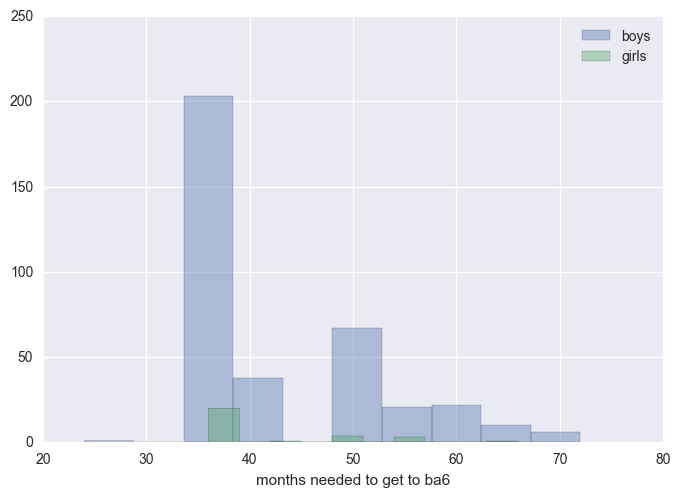

In [33]:
sns.distplot(bachelor_df_filtered.duration[bachelor_df_filtered.gender=='male'],bins=10,
             kde=False,axlabel='months needed to get to ba6',label='boys')
sns.distplot(bachelor_df_filtered.duration[bachelor_df_filtered.gender=='female'],bins=10,
             kde=False,axlabel='months needed to get to ba6',label='girls')
plt.legend()

Here we estimate the _non-gaussianity_ with the kurtosis (kurtosis of Gaussian distribution is equal to 0):

In [34]:
import scipy.stats as stats

In [35]:
duration_male = bachelor_df_filtered[bachelor_df_filtered.gender=='male'].duration
duration_female = bachelor_df_filtered[bachelor_df_filtered.gender=='female'].duration

In [36]:
print(stats.kurtosis(duration_female))
print(stats.kurtosis(duration_male))

1.5111464732986768
0.9149707477894959


### Statistical test(s)

As the distributions above are not gaussian, we choose the KS test, to compare them:

In [37]:
stats.ks_2samp(duration_male, duration_female)

Ks_2sampResult(statistic=0.13530734632683661, pvalue=0.67665439629670598)

As the p-value of this test is > 0.01, we keep the null hypothesis, namely the samples are likely to come from the same distribution.

In order to be sure that this is not an artifact of the specific test used, we try another similar test. KS test is _not very sensitive to tails of the  distributions_ (http://stats.stackexchange.com/questions/201434/2-sample-kolmogorov-smirnov-vs-anderson-darling-vs-cramer-von-mises) and therefore we check the statistical significance also with the Anderson test (https://en.wikipedia.org/wiki/Anderson%E2%80%93Darling_test):

In [38]:
stats.anderson_ksamp([duration_female,duration_male])

Anderson_ksampResult(statistic=0.44883751041503511, critical_values=array([ 0.325,  1.226,  1.961,  2.718,  3.752]), significance_level=0.21937273587968528)

Also AD test (p-value > 0.01) _supports_ the KS conclusion: the two samples are likely to come from the same distribution.

## 2. Master duration

In this part, we want to do the same kind of computation for master students.

In [16]:
try:
    os.mkdir(local_dir)
except FileExistsError:
    # directory exists
    print("Using existing '" + local_dir + "' directory")

Using existing '.local-data' directory


First we get the data :

In [40]:
# Fixed values
params_dict = {
    'ww_x_GPS': -1,
    'ww_i_reportModel': 133685247,
    'ww_i_reportModelXsl': 133685270,
    'ww_x_UNITE_ACAD': acad_unit['Informatique']
}

# Iterate over all the varying params and keep only data for bachelors
for year_key, year_value in acad_period.items():
    for level_key, level_value in level.items():
        for semester_key, semester_value in semester.items():
            if 'master' in level_key.lower():
                params_dict['ww_x_PERIODE_ACAD'] = year_value
                params_dict['ww_x_PERIODE_PEDAGO'] = level_value
                params_dict['ww_x_HIVERETE'] = semester_value
                
                df = get_data(base_url, params_dict)
                if not df.empty:
                    # Persist dataframe locally with pickle
                    filename = year_key + '-' + level_key.replace(' ', '-').lower() + '-' + semester_key
                    df.to_pickle(local_dir + '/' + filename)

In [17]:
ma1_dfs, ma2_dfs, ma3_dfs, projma_dfs = {}, {}, {}, {}
ma1 = 'master-semestre-1'
ma2 = 'master-semestre-2'
ma3 = 'master-semestre-3'
projma = 'projet-master'

# For each academic year, get data about masters 1-2-3 and projet master
for year_key, year_value in acad_period.items():
    for file in os.listdir(local_dir):
        
        # Read the data and put where it belongs
        if (year_key in file) and (ma1 in file):
            df = pd.read_pickle(local_dir + '/' + file)
            df['ma1'] = year_key
            ma1_dfs[year_key] = df
            
        if (year_key in file) and (ma2 in file): 
            df = pd.read_pickle(local_dir + '/' + file)
            df['ma2'] = year_key
            ma2_dfs[year_key] = df
            
        if (year_key in file) and (ma3 in file): 
            df = pd.read_pickle(local_dir + '/' + file)
            df['ma3'] = year_key
            ma3_dfs[year_key] = df
            
        if (year_key in file) and (projma in file): 
            df = pd.read_pickle(local_dir + '/' + file)
            df['projma'] = year_key
            projma_dfs[year_key] = df

Then, we concatenate dataframes by academic level :

In [18]:
# Concatenate all 'MA{i}' or 'Projet MA' together
ma1_df_concat = pd.concat(ma1_dfs.values(), axis=0)
ma2_df_concat = pd.concat(ma2_dfs.values(), axis=0)
ma3_df_concat = pd.concat(ma3_dfs.values(), axis=0)
projma_df_concat = pd.concat(projma_dfs.values(), axis=0)

Now we can count how many times each student has done each semester :

In [19]:
count_ma1 = pd.DataFrame(ma1_df_concat.groupby('sciper',as_index=False).size(), columns=['count_ma1'])
count_ma1['sciper'] = count_ma1.index
count_ma2 = pd.DataFrame(ma2_df_concat.groupby('sciper',as_index=False).size(), columns=['count_ma2'])
count_ma2['sciper'] = count_ma2.index
count_ma3 = pd.DataFrame(ma3_df_concat.groupby('sciper',as_index=False).size(), columns=['count_ma3'])
count_ma3['sciper'] = count_ma3.index
count_projma = pd.DataFrame(projma_df_concat.groupby('sciper',as_index=False).size(), columns=['count_projma'])
count_projma['sciper'] = count_projma.index

Finally we build a big dataframe with all the info in it :

In [36]:
masters_df = pd.merge(ma1_df_concat, ma2_df_concat, how='outer')
masters_df = pd.merge(masters_df, ma3_df_concat, how='outer')
masters_df = pd.merge(masters_df, projma_df_concat, how='outer')

masters_df = pd.merge(masters_df, count_ma1, how='outer')
masters_df['count_ma1'] = masters_df['count_ma1'].fillna(value=0)
masters_df = pd.merge(masters_df, count_ma2, how='outer')
masters_df['count_ma2'] = masters_df['count_ma2'].fillna(value=0)
masters_df = pd.merge(masters_df, count_ma3, how='outer')
masters_df['count_ma3'] = masters_df['count_ma3'].fillna(value=0)
masters_df = pd.merge(masters_df, count_projma, how='outer')
masters_df['count_projma'] = masters_df['count_projma'].fillna(value=0)

masters_df_all = masters_df.drop_duplicates(['sciper'], keep='last').copy()

masters_df_all.head()

,gender,full_name,specialization,minor,status,sciper,ma1,ma2,ma3,projma,count_ma1,count_ma2,count_ma3,count_projma
1,female,Abbadi Hajar,NaN,"Mineur en Management, technologie et entrepren...",Présent,238067,NaN,2013-2014,2014-2015,NaN,1.0,1.0,1.0,0.0
3,male,Ahmed Fayzan,NaN,Mineur en Neuroprosthétiques,Présent,235799,NaN,2013-2014,2014-2015,NaN,1.0,1.0,1.0,0.0
5,male,Angel Axel,NaN,NaN,Stage,201284,NaN,NaN,2014-2015,NaN,1.0,1.0,1.0,0.0
7,female,Antic Jelena,NaN,NaN,Stage,233437,NaN,NaN,2014-2015,NaN,1.0,1.0,1.0,0.0
11,male,Antognini Marco,Foundations of Software,NaN,Présent,194182,NaN,2015-2016,2015-2016,2016-2017,2.0,3.0,1.0,1.0


### Compute time spent in Master  (so far)

In [37]:
columns = ['count_ma1', 'count_ma2', 'count_ma3', 'count_projma']
masters_df_all['duration'] = masters_df_all.apply(compute_duration, axis=1, args=(columns,))
msc_duration = masters_df_all['duration']
msc_duration.unique()

array([ 18.,  42.,  36.,  24.,  30.,  12.,   6.,  48.])

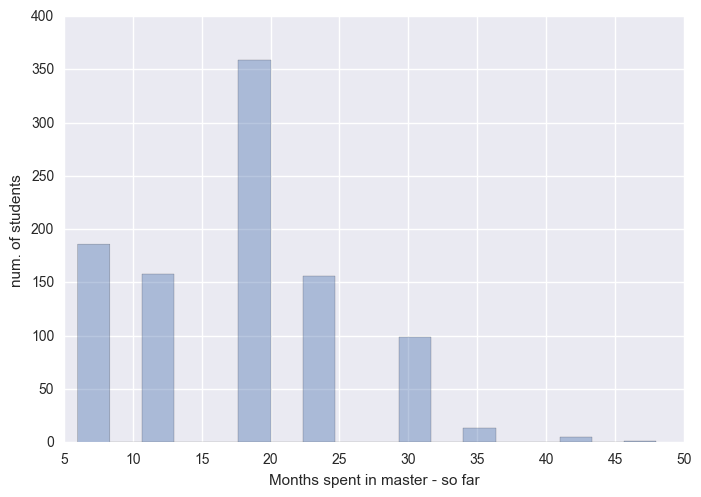

In [38]:
sns.distplot(msc_duration,kde=False,axlabel='Months spent in master - so far')
plt.ylabel('num. of students')

### Some stats

We can know have some stats, about all students first :

In [39]:
msc_duration.describe()

count    977.000000
mean      17.312180
std        7.832375
min        6.000000
25%       12.000000
50%       18.000000
75%       24.000000
max       48.000000
Name: duration, dtype: float64

So the "average stay" for a master student at EPFL would be around 18 months.

Now let's extract students with a specialization :

In [45]:
masters_df_spe = masters_df[masters_df.specialization.notnull()]
masters_df_spe = masters_df_spe.drop_duplicates(['sciper'], keep='last')
masters_df_spe['duration'] = masters_df_spe.apply(compute_duration, axis=1, args=(columns,))
masters_df_spe.head()

,gender,full_name,specialization,minor,status,sciper,ma1,ma2,ma3,projma,count_ma1,count_ma2,count_ma3,count_projma,duration
11,male,Antognini Marco,Foundations of Software,NaN,Présent,194182,NaN,2015-2016,2015-2016,2016-2017,2.0,3.0,1.0,1.0,42.0
17,male,Ardelean Alexandru,Internet computing,NaN,Présent,238168,NaN,2013-2014,2014-2015,NaN,1.0,1.0,1.0,0.0,18.0
24,male,Bastin Cédric,Foundations of Software,NaN,Stage,204179,NaN,NaN,2014-2015,NaN,1.0,2.0,1.0,0.0,24.0
31,male,Beguet Eric,Foundations of Software,NaN,Stage,204103,NaN,2014-2015,NaN,NaN,1.0,2.0,1.0,0.0,24.0
36,male,Berdat Johan,"Signals, Images and Interfaces",NaN,Stage,204393,NaN,NaN,2016-2017,NaN,2.0,3.0,2.0,0.0,42.0


Then we can compute the "average stay" per specialization :

In [55]:
masters_df_spe_grp = masters_df_spe.groupby(masters_df_spe.specialization).mean()
masters_df_spe_grp

,count_ma1,count_ma2,count_ma3,count_projma,duration
specialization,,,,,
Biocomputing,0.333333,0.583333,1.166667,0.166667,13.500000
Computer Engineering - SP,1.000000,1.363636,1.045455,0.090909,21.000000
Computer Science Theory,1.000000,1.000000,1.000000,0.000000,18.000000
Data Analytics,1.125000,0.750000,0.500000,0.000000,14.250000
Foundations of Software,1.014493,1.478261,1.101449,0.101449,22.173913
Information Security - SP,1.000000,1.285714,1.000000,0.285714,21.428571
Internet Information Systems,1.000000,1.000000,1.000000,0.000000,18.000000
Internet computing,0.898148,1.407407,1.148148,0.101852,21.333333
Service science,1.000000,1.333333,1.000000,0.000000,20.000000
